In [ ]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

from diffusers import UNet2DModel
from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *

In [ ]:
set_seed(1103, False)

In [ ]:
mpl.rcParams['image.cmap'] = 'gray'
logging.disable(logging.WARNING)

In [ ]:
fm_x, fm_y = "img", "label"
name = "cifar10"
ds = load_dataset(name)

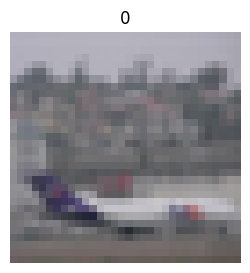

In [ ]:
img = ds["train"][0][fm_x]
label = ds["train"][0][fm_y]
show_image(img, title=label, figsize=(3,3));

In [ ]:
img.width, img.height

(32, 32)

In [ ]:
img = TF.to_tensor(img)
img.min(), img.max(), img.mean(), img.std()

(tensor(0.1333), tensor(0.7961), tensor(0.4918), tensor(0.1333))

In [ ]:
@inplace
def transformi(b):
    b[fm_x] = [TF.to_tensor(i) - 0.5 for i in b[fm_x]]
dst = ds.with_transform(transformi)

bs = 32
dls = DataLoaders.from_dd(dst, bs)
xb, yb = next(iter(dls.train))

In [ ]:
class Schedule:
    def __init__(self, alphas, betas, alphas_bar, sigmas, n_steps):
        fc.store_attr()

In [ ]:
def linear_sched(beta_min=0.0001, beta_max=0.02, n_steps=1000):
    betas = torch.linspace(beta_min, beta_max, n_steps)
    alphas = 1 - betas
    alphas_bar = torch.cumprod(alphas, 0)
    sigmas = betas.sqrt()
    return Schedule(alphas, betas, alphas_bar, sigmas, n_steps)

In [ ]:
schedule = linear_sched()

In [ ]:
def add_noise(x, schedule=schedule):
    device = x.device
    bs = x.shape[0]

    t = torch.randint(0, schedule.n_steps, (bs,), dtype=torch.int64)
    alpha_bar_t = schedule.alphas_bar[t][:, None, None, None].to(device)
    
    original_part = alpha_bar_t.sqrt() * x
    epsilon = torch.randn(x.shape, device=device)
    noise_part = (1 - alpha_bar_t).sqrt() * epsilon

    xt = original_part + noise_part
    return (xt, t.to(device)), epsilon

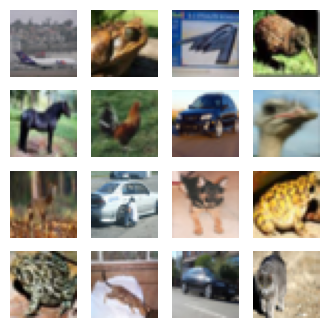

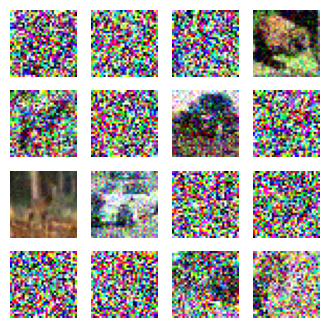

In [ ]:
show_images(xb[:16]+0.5, imsize=1)
show_images(add_noise(xb[:16])[0][0]+0.5, imsize=1);

# Training

In [ ]:
def get_collate_ddpm(schedule=schedule):
    def _collate_ddpm(b):
        return add_noise(default_collate(b)[fm_x], schedule)
    return _collate_ddpm

collate_ddpm = get_collate_ddpm(schedule)

In [ ]:
def dl_ddpm(ds):
    return DataLoader(ds, batch_size=bs*2, collate_fn=collate_ddpm, num_workers=4)

In [ ]:
def sample(model, sz, schedule=schedule, minv=-0.5, maxv=0.5):
        device = next(model.parameters()).device
        with torch.no_grad():
            x = torch.randn(sz, device=device)
            bs = x.shape[0]
            process = []
    
            for t in reversed(range(schedule.n_steps)):
                t_batch = torch.full((bs,), t, dtype=torch.int64)
    
                # Repametrized equation (4)
                noise_pred = model((x, t_batch.to(device)))
                alpha_bar_t = schedule.alphas_bar[t]
                x0_est = (x - (1 - alpha_bar_t).sqrt() * noise_pred) * (1 / alpha_bar_t.sqrt())
                x0_est = x0_est.clamp(minv, maxv)
    
                # Equations (7) and (8)
                alpha_bar_t_minus_1 = torch.tensor(1) if t == 0 else schedule.alphas_bar[t - 1]
                x0_coef = alpha_bar_t_minus_1.sqrt() * schedule.betas[t] / (1 - alpha_bar_t)
                xt_coef = schedule.alphas[t].sqrt() * (1 - alpha_bar_t_minus_1) / (1 - alpha_bar_t)
                noise_sample = torch.zeros(x.shape, device=device) if t == 0 else torch.randn(x.shape, device=device)
                x = x0_coef * x0_est + x * xt_coef + schedule.sigmas[t] * noise_sample
    
                process.append(to_cpu(x))
    
        return process

In [ ]:
class UNet(UNet2DModel):
    def forward(self, x):
        return super().forward(*x).sample

In [ ]:
def init_ddpm(model):
    for down_block in model.down_blocks:
        for resnet in down_block.resnets:
            resnet.conv2.weight.data.zero_()
        downsamplers = down_block.downsamplers
        if not downsamplers: downsamplers = []
        for downsampler in downsamplers:
            init.orthogonal_(downsampler.conv.weight)

    model.conv_out.weight.data.zero_()

In [ ]:
UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 64), norm_num_groups=8).num_parameters()

1695457

In [ ]:
UNet().num_parameters()

274056163

In [ ]:
UNet.__init__

<function diffusers.models.unet_2d.UNet2DModel.__init__(self, sample_size: Union[int, Tuple[int, int], NoneType] = None, in_channels: int = 3, out_channels: int = 3, center_input_sample: bool = False, time_embedding_type: str = 'positional', freq_shift: int = 0, flip_sin_to_cos: bool = True, down_block_types: Tuple[str] = ('DownBlock2D', 'AttnDownBlock2D', 'AttnDownBlock2D', 'AttnDownBlock2D'), up_block_types: Tuple[str] = ('AttnUpBlock2D', 'AttnUpBlock2D', 'AttnUpBlock2D', 'UpBlock2D'), block_out_channels: Tuple[int] = (224, 448, 672, 896), layers_per_block: int = 2, mid_block_scale_factor: float = 1, downsample_padding: int = 1, downsample_type: str = 'conv', upsample_type: str = 'conv', dropout: float = 0.0, act_fn: str = 'silu', attention_head_dim: Optional[int] = 8, norm_num_groups: int = 32, attn_norm_num_groups: Optional[int] = None, norm_eps: float = 1e-05, resnet_time_scale_shift: str = 'default', add_attention: bool = True, class_embed_type: Optional[str] = None, num_class_em

In [ ]:
down = 2
UNet(in_channels=3, out_channels=3, block_out_channels=(224 // down, 448 // down, 672 // down, 896 // down), norm_num_groups=32 // down).num_parameters()

68562931

In [ ]:
down = 4
UNet(in_channels=3, out_channels=3, block_out_channels=(224 // down, 448 // down, 672 // down, 896 // down), norm_num_groups=32 // down).num_parameters()

17165179

In [ ]:
clean_mem()

loss,epoch,train
0.112,0,train
0.024,0,valid


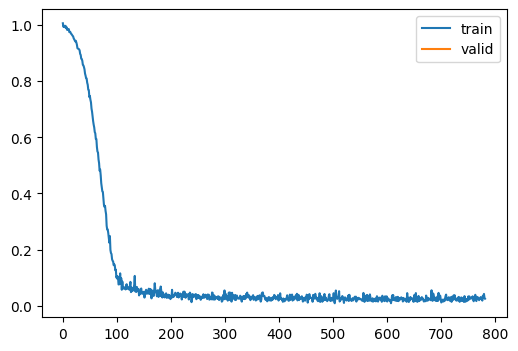

In [ ]:
dls = DataLoaders(dl_ddpm(dst["train"]), dl_ddpm(dst["test"]))

set_seed(1103, False)
lr = 0.001
epochs = 1
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))
cbs = [DeviceCB(), ProgressCB(True), MetricsCB(), sched]

down = 4
model = UNet(in_channels=3, out_channels=3, block_out_channels=(224//down, 448//down, 672//down, 896//down), norm_num_groups=32//down)
init_ddpm(model)

opt_func = partial(optim.AdamW, eps=1e-4)

learn = TrainLearner(model, dls, F.mse_loss, lr=lr, cbs=cbs, opt_func=opt_func)
learn.fit(epochs)

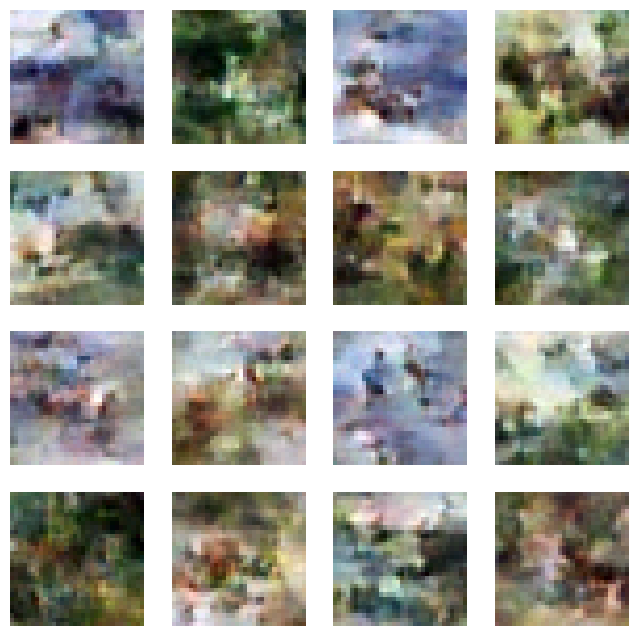

In [ ]:
set_seed(1103, False)
show_images(sample(model, (16, 3, 32, 32), schedule)[-1] + 0.5, imsize=2)

# W&B CB

In [ ]:
import wandb

In [ ]:
wandb.init

<function wandb.sdk.wandb_init.init(job_type: Optional[str] = None, dir: Union[str, ForwardRef('os.PathLike[str]'), NoneType] = None, config: Union[Dict, str, NoneType] = None, project: Optional[str] = None, entity: Optional[str] = None, reinit: Optional[bool] = None, tags: Optional[Sequence] = None, group: Optional[str] = None, name: Optional[str] = None, notes: Optional[str] = None, magic: Union[dict, str, bool, NoneType] = None, config_exclude_keys: Optional[List[str]] = None, config_include_keys: Optional[List[str]] = None, anonymous: Optional[str] = None, mode: Optional[str] = None, allow_val_change: Optional[bool] = None, resume: Union[bool, str, NoneType] = None, force: Optional[bool] = None, tensorboard: Optional[bool] = None, sync_tensorboard: Optional[bool] = None, monitor_gym: Optional[bool] = None, save_code: Optional[bool] = None, id: Optional[str] = None, settings: Union[wandb.sdk.wandb_settings.Settings, Dict[str, Any], NoneType] = None) -> Union[wandb.sdk.wandb_run.Run,

In [ ]:
wandb.finish

<function wandb.sdk.wandb_run.finish(exit_code: Optional[int] = None, quiet: Optional[bool] = None) -> None>

In [ ]:
wandb.log

<function wandb.sdk.lib.preinit.PreInitCallable.<locals>.preinit_wrapper(self, data: Dict[str, Any], step: Optional[int] = None, commit: Optional[bool] = None, sync: Optional[bool] = None) -> None>

In [ ]:
class WandBCB(MetricsCB):
    order = 10000
    def __init__(self, config, *ms, sample_size=16, project="fastai_gen_cifar10", **metrics):
        self.sample_size = sample_size
        self.config = config
        self.project = project
        super().__init__(*ms, **metrics)

    def before_fit(self, learn):
        super().before_fit(learn)
        wandb.init(project=self.project, config=self.config)

    def after_fit(self, learn):
        wandb.finish()

    def log(self, d):
        prefix = "train_"
        if not self.learn.training:
            prefix = "val_"
            wandb.log({"sample": self.sample_figure(self.learn)})
        wandb.log({prefix + name: float(d[name]) for name in self.all})
        print(d)

    def sample_figure(self, learn):
        samples = sample(learn.model, (self.sample_size, 3, 32, 32))[-1]
        samples = (samples + 0.5).clip(0., 1.)
        plt.clf()
        fig, axs = get_grid(self.sample_size)
        for s, ax in zip(samples, axs.flat):
            show_image(s, ax=ax)
        return fig

    def after_batch(self, learn):
        super().after_batch(learn)
        prefix = "train_" if learn.training else "val_"
        wandb.log({prefix+"loss": learn.loss})

In [ ]:
dls = DataLoaders(dl_ddpm(dst["train"]), dl_ddpm(dst["test"]))

seed = 1103
set_seed(seed, False)
lr = 0.0005
epochs = 3
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))

down = 4
model = UNet(in_channels=3, out_channels=3, block_out_channels=(224//down, 448//down, 672//down, 896//down), norm_num_groups=32//down)
init_ddpm(model)

wandb_cb = WandBCB(config={"seed": seed, "lr": lr, "epochs": epochs, "down": down})
cbs = [DeviceCB(), ProgressCB(True), wandb_cb, sched]
opt_func = partial(optim.AdamW, eps=1e-4)

learn = TrainLearner(model, dls, F.mse_loss, lr=lr, cbs=cbs, opt_func=opt_func)
learn.fit(epochs)

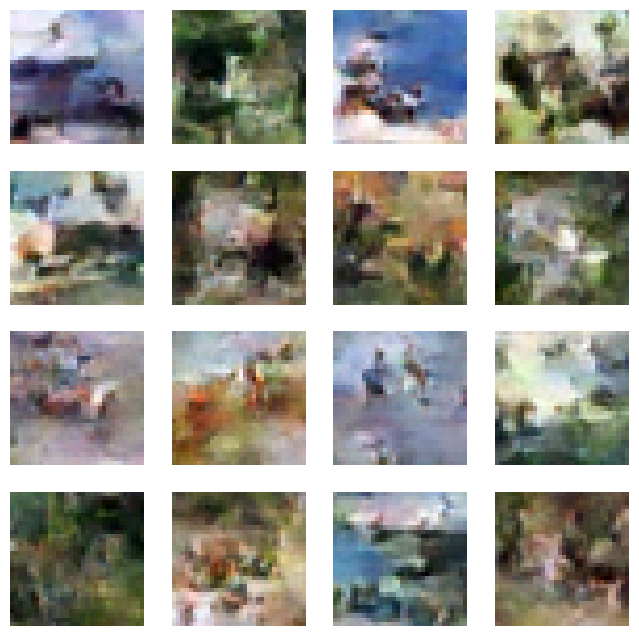

In [ ]:
set_seed(1103, False)
samples = sample(model, (16, 3, 32, 32), schedule)[-1] + 0.5
show_images(samples, imsize=2)